### **Bone Fracture Detection Using Computer Vision**  

#### **Project Overview and Key Features**  
This project leverages computer vision techniques to detect bone fractures from medical images, such as X-rays or CT scans. The goal is to build a robust system capable of automating the detection process to assist healthcare professionals in diagnosing fractures accurately and efficiently.  

**Key Features:**  
1. **Automated Preprocessing**: Efficiently prepares raw medical images for analysis.  
2. **Segmentation**: Identifies and isolates the regions of interest (bones) in the images.  
3. **Feature Extraction**: Extracts meaningful patterns from segmented images, such as fracture edges or anomalies.  
4. **Classification**: Utilizes machine learning or deep learning models to classify images as fractured or non-fractured.  
5. **Performance Metrics**: Measures the accuracy, precision, recall, and F1-score of the detection network.  

---

#### **Dataset Description**  
- **Source**: Publicly available medical imaging datasets like the MURA dataset or datasets from Kaggle and AI healthcare repositories.  
- **Types of Images**: X-rays or CT scans with labeled fractures and non-fractures.  
- **Format**: Typically stored in `.jpg`, `.png`, or DICOM formats with accompanying annotations (e.g., JSON, CSV).  

---

#### **Steps to Build the Project**  

### **1. Reading and Preprocessing the Dataset**  
- **Image Normalization**: Scale pixel values between 0 and 1 for uniformity.  
- **Data Augmentation**: Apply transformations like rotation, zoom, flipping, and contrast adjustment to increase dataset diversity.  
- **Resizing**: Resize images to a standard size compatible with the neural network input dimensions.  
- **Label Encoding**: Convert textual labels into numeric values for classification.  

**Tools**: Python libraries like NumPy, OpenCV, and TensorFlow/Keras.  

---

### **2. Image Segmentation**  
- **Goal**: Isolate the bone structure from the background to improve feature extraction accuracy.  
- **Techniques**:  
  - Thresholding  
  - Edge Detection (e.g., Canny, Sobel filters)  
  - Deep Learning (e.g., U-Net or Mask R-CNN for precise segmentation)  

**Tools**: OpenCV, scikit-image, TensorFlow/Keras, PyTorch.  

---

### **3. Feature Extraction**  
- **Traditional Techniques**: Histogram of Oriented Gradients (HOG), Local Binary Patterns (LBP).  
- **Deep Learning**: Utilize pretrained convolutional neural networks (CNNs) like ResNet, VGG, or custom CNN layers to extract features automatically.  

**Tools**: TensorFlow/Keras, PyTorch.  

---

### **4. Classification**  
- **Approach**:  
  - Use supervised learning algorithms such as CNNs or transfer learning with pretrained models like EfficientNet or DenseNet.  
  - Ensure a binary classification output (fractured vs. non-fractured).  
- **Model Optimization**: Use hyperparameter tuning (e.g., learning rate, number of layers) to optimize performance.  

**Tools**: TensorFlow/Keras, PyTorch, scikit-learn.  

---

### **5. Accuracy and Evaluation of the Network**  
- **Metrics**:  
  - **Accuracy**: Percentage of correctly classified images.  
  - **Precision and Recall**: Measure the model’s reliability in detecting fractures.  
  - **F1-Score**: Balance between precision and recall.  
  - **ROC-AUC Curve**: Evaluate the model’s ability to differentiate between classes.  
- **Cross-Validation**: Ensure generalization and robustness using k-fold cross-validation.  

**Tools**: Matplotlib, scikit-learn.  

---

#### **Deliverables**  
1. Preprocessed dataset.  
2. Code for segmentation, feature extraction, and classification.  
3. Trained model for fracture detectios.

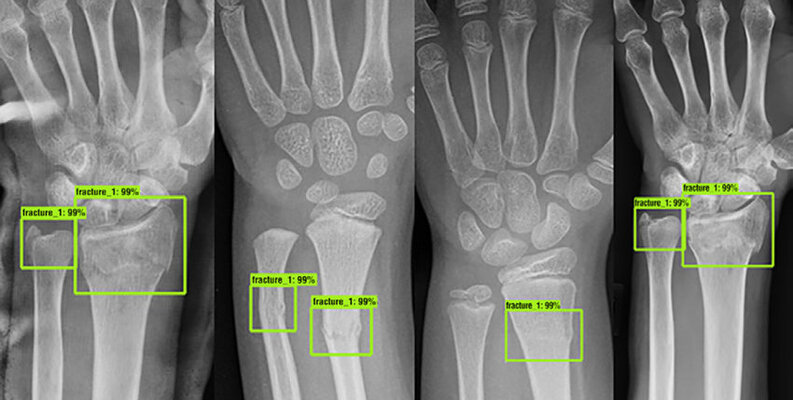

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# used to find all the pathnames matching
import glob as gb
import cv2  
import pickle
import random
from skimage.feature import graycomatrix
from skimage.feature import graycoprops   # Extracts properties like contrast, correlation from the GLCM
from skimage.color import rgb2gray

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report , confusion_matrix , ConfusionMatrixDisplay ,  precision_recall_curve, roc_auc_score, roc_curve
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

### About the Dataset
1. **Content**:
   - The dataset consists of X-ray images categorized as either fractured or non-fractured.
   - Images represent various joints, primarily in the **upper extremities** (e.g., shoulder, elbow, wrist, hand, etc.).
   
2. **Objective**:
   - The main task is to build an image classifier that can detect fractures from the given X-ray images.
   - Preprocessing and isolating individual joints (if the dataset contains mixed joints in one image) are recommended to enhance classifier accuracy.

3. **Classes**:
   - The dataset typically contains **two primary classes**:
     - **Fractured (1)**: X-ray images showing fractures.
     - **Non-Fractured (0)**: X-ray images without fractures.

4. **Challenges**:
   - **Class imbalance**: Medical datasets often have more non-fractured cases than fractured ones.
   - **Intra-class variability**: Differences in fracture appearance based on type, severity, and joint location.
   - **Inter-class similarity**: Certain non-fractured anomalies might visually resemble fractures.

# Read Dataset 

In [3]:
path_train = r"D:\Downloads\archive (1)\archive (6)\train"

for folder in os.listdir(path=path_train) :
    file_folder = os.path.join(path_train , folder)
    files = gb.glob(pathname=os.path.join(file_folder , "*.jpg"))
    print(f"Training Data,Found {len(files)} in folder {folder}")


Training Data,Found 4477 in folder fractured
Training Data,Found 4381 in folder not fractured


In [4]:
path_test = r"D:\Downloads\archive (1)\archive (6)\test"

for folder in os.listdir(path=path_test) :
    file_folder = os.path.join(path_test , folder)
    files = gb.glob(pathname=os.path.join(file_folder , "*.jpg"))
    print(f"Testing Data,Found {len(files)} in folder {folder}")


Testing Data,Found 359 in folder fractured
Testing Data,Found 239 in folder not fractured


# Segmentation

In [5]:
def segment_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0) # standard deviation in the X and Y directions
    _, thr = cv2.threshold(blur, 127, 255, cv2.THRESH_BINARY)
                                        #  retrieval mode only retrieves the external contours of objects
    contours, _ = cv2.findContours(thr, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # reduces the amount of data stored in the contour
    mask = np.zeros_like(image) 
    cv2.drawContours(mask, contours, -1, (255, 255, 255), thickness=cv2.FILLED)
    return cv2.bitwise_and(image, mask)

# Feature extraction By Chain Code, Regional Features, GLCM, and LBP

In [6]:
def prepare_image(image, method):
    # Convert to grayscale for methods that require it
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # LBP also applies histogram equalization for better lighting normalization
    if method == 'LBP':
        gray = cv2.equalizeHist(gray)

    return gray

## feature_extraction_chain_code

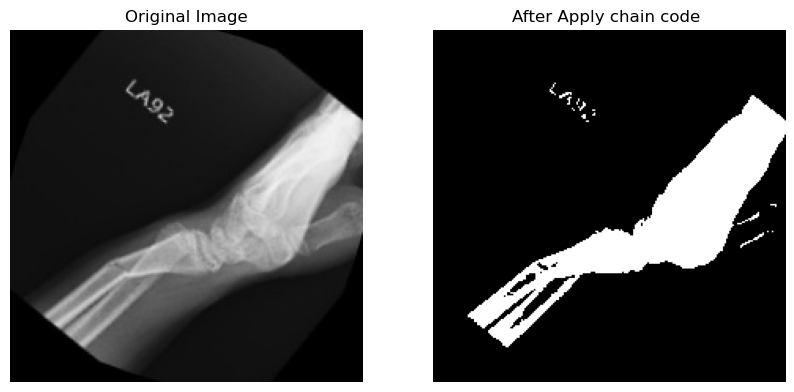

Extracted Chain Code Features: [7 8 7 ... 0 0 0]


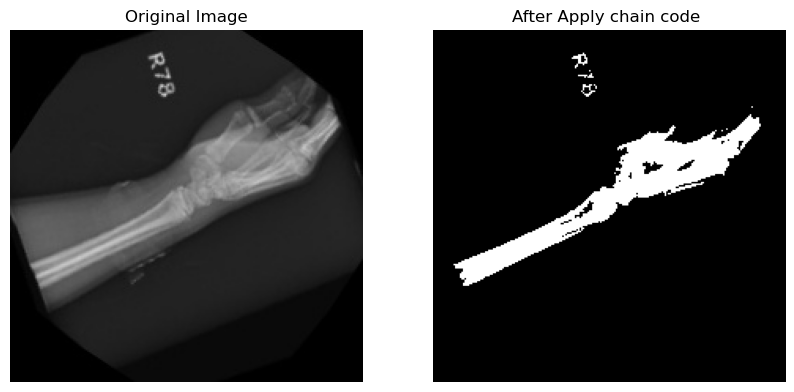

Extracted Chain Code Features: [7 8 7 ... 0 0 0]


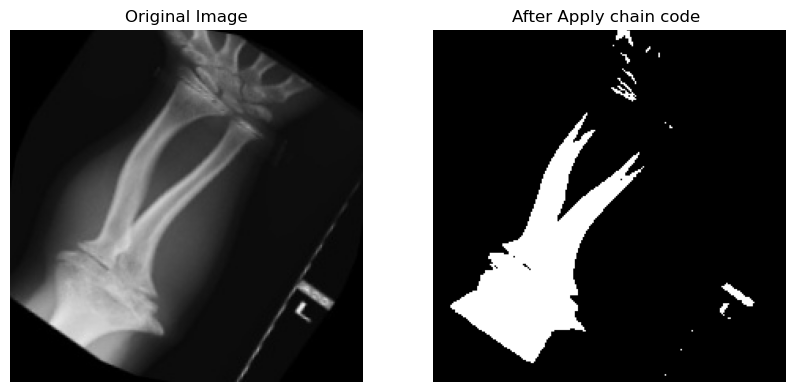

Extracted Chain Code Features: [4 6 7 ... 0 0 0]


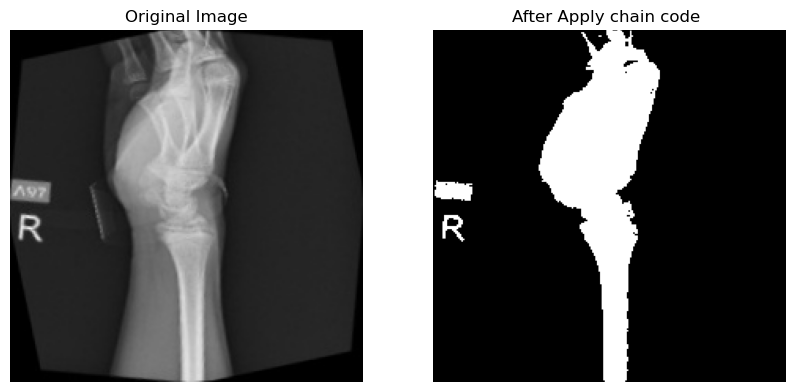

Extracted Chain Code Features: [6 7 6 ... 0 0 0]


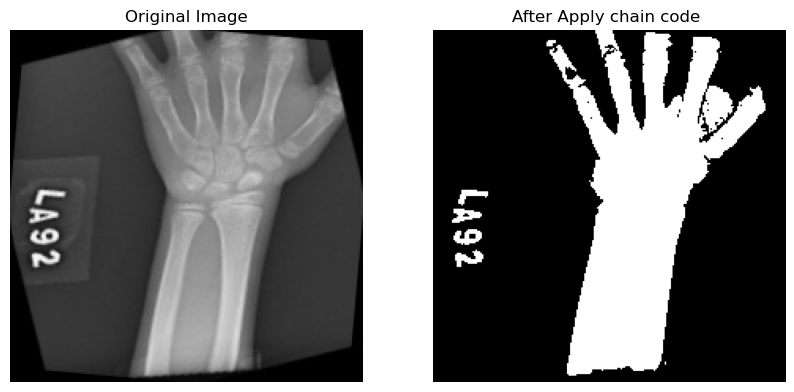

Extracted Chain Code Features: [6 7 8 ... 0 0 0]


In [7]:
def feature_extraction_chain_code(image, show_images=False):

    gray = prepare_image(image, 'chain_code')
    ret, thresh = cv2.threshold(gray, 127, 255, 0) 
                                              # Retrieves all contours and organizes them hierarchically
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # reduces the amount of data stored in the contour

    # Generate chain code
    chain_code = []
    for contour in contours:
        contour = contour.reshape(-1, 2)
        for i in range(1, len(contour)):
            dx = contour[i][0] - contour[i-1][0]
            dy = contour[i][1] - contour[i-1][1]
            direction = (np.arctan2(dy, dx) + np.pi) // (np.pi / 4)
            chain_code.append(int(direction))
   
                                                                     # type
    chain_code = np.pad(chain_code, (0, 2048 - len(chain_code)), 'constant')[:2048]

    # Optionally show images
    if show_images:
        plt.figure(figsize=(10, 5))

        # Show the original image
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title("Original Image")
        plt.axis("off")

        # Show the thresholded image
        plt.subplot(1, 2, 2)
        plt.imshow(thresh, cmap="gray")
        plt.title("After Apply chain code ")
        plt.axis("off")

        plt.show()

    return chain_code


image_paths = gb.glob(os.path.join(path_train, '*/*.jpg'))  # Get all image paths
random_images = random.sample(image_paths, 5)  # Randomly select 5 unique images

for image_path in random_images:
    image = cv2.imread(image_path)
    ch_code = feature_extraction_chain_code(image, show_images=True)
    print(f"Extracted Chain Code Features: {ch_code}")

# feature_extraction_regional

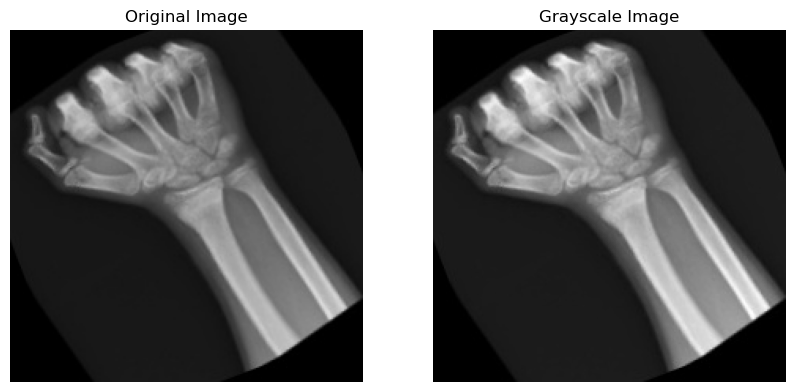

Extracted regional Features: [  56.72441008 3241.25014235    5.71630296]


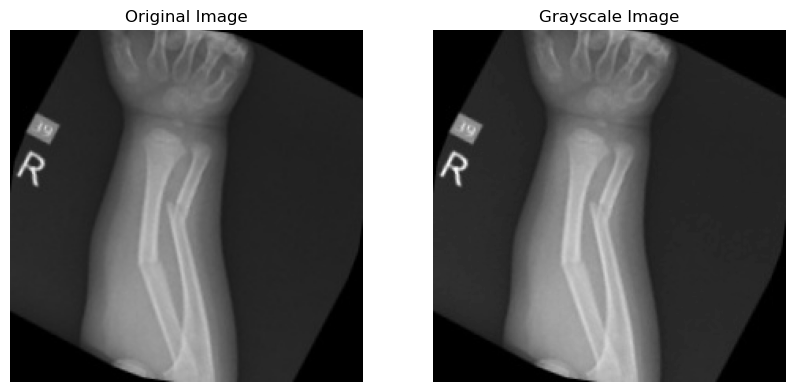

Extracted regional Features: [  61.54711416 2589.13748848    5.99930508]


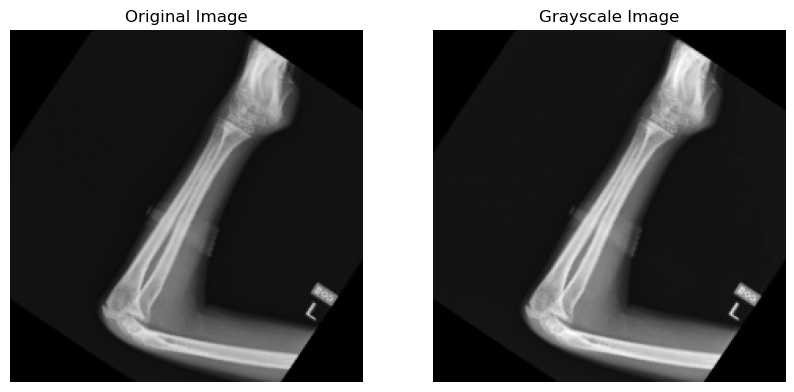

Extracted regional Features: [  39.91882573 2785.75339559    4.44567138]


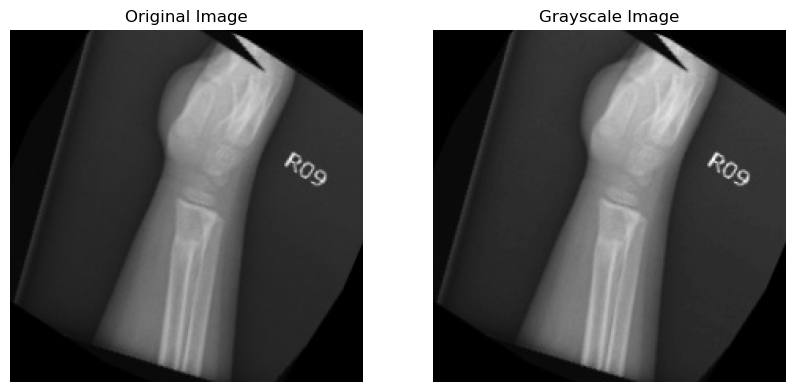

Extracted regional Features: [  56.70302535 2574.41748606    6.28897314]


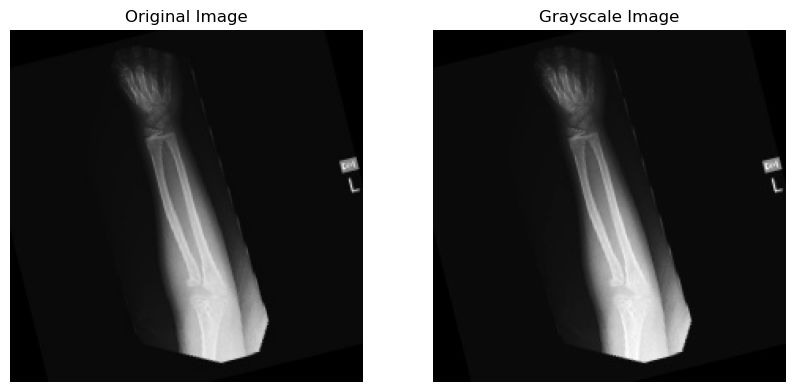

Extracted regional Features: [  28.49095185 2465.86977623    3.69066492]


In [ ]:
def regional_Descriptor(image):
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    inverted_binary = ~binary

    _, thr = cv2.threshold(image, 127, 255, cv2.THRESH_OTSU)
    
    inverted_binary = ~thr
                                       
       
    contours, _ = cv2.findContours(inverted_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 
    
   
    
    with_contours=cv2.drawContours(image, contours, -1, (255, 255, 255))
    
    object=contours[0]
    print('contours= ',object)
    area=cv2.contourArea(object)
    perimeter=cv2.arcLength(object,True)
    compactness=(4*np.pi*area)/(perimeter**2)
    
    return area , perimeter , compactness

# feature_extraction_lbp 

Extracted LPB Features: [[8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]
 ...
 [8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]]
Extracted LPB Features: [[8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]
 ...
 [8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]]
Extracted LPB Features: [[8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]
 ...
 [8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]]
Extracted LPB Features: [[8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]
 ...
 [8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]]
Extracted LPB Features: [[8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]
 ...
 [8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]]


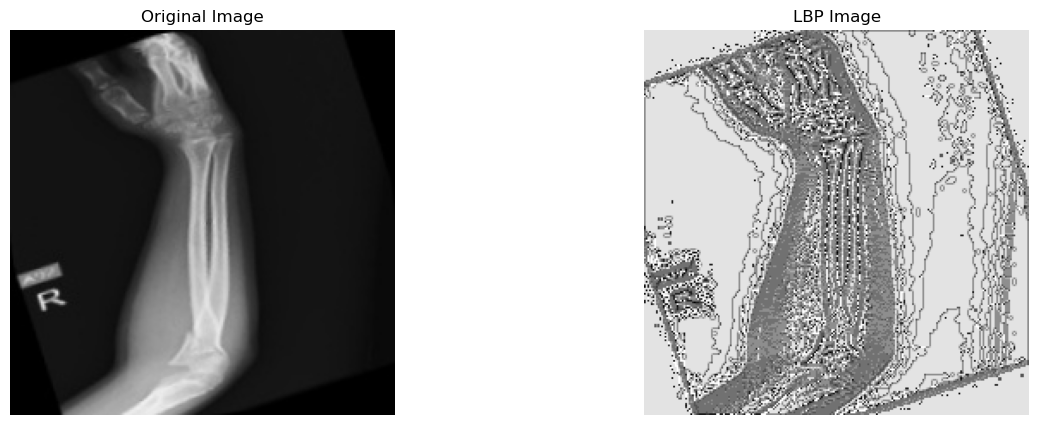

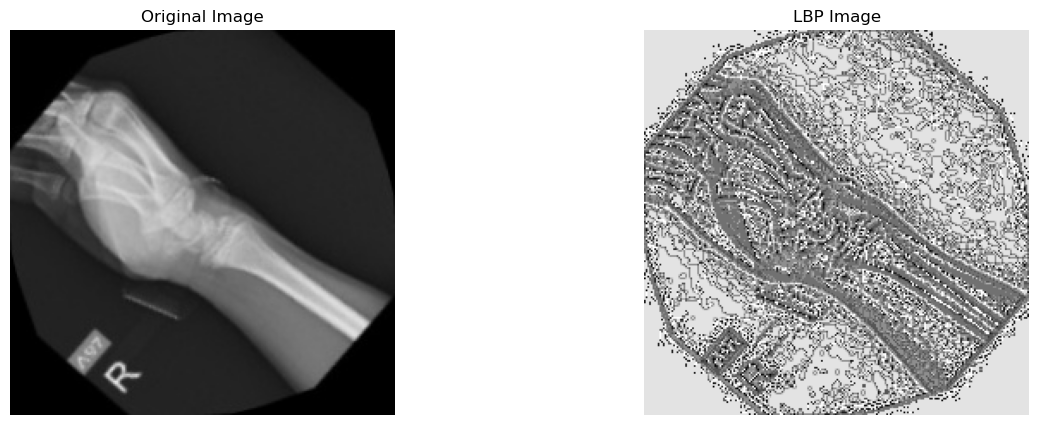

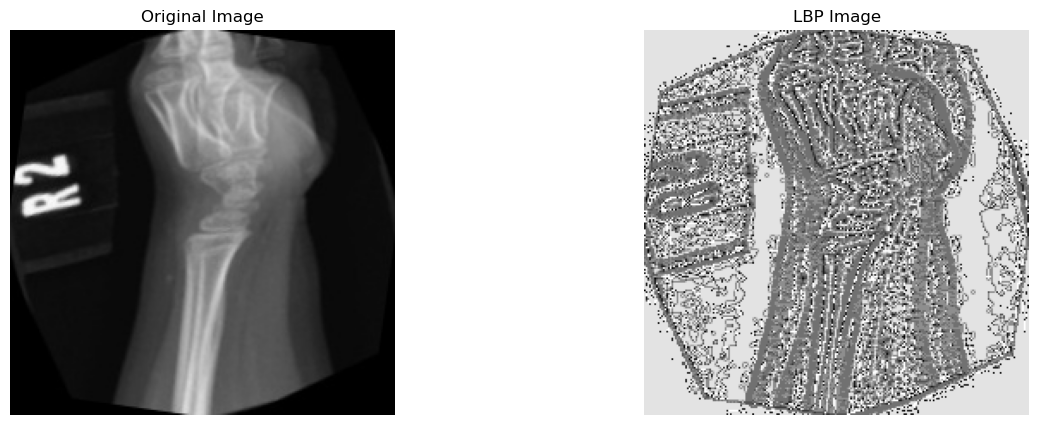

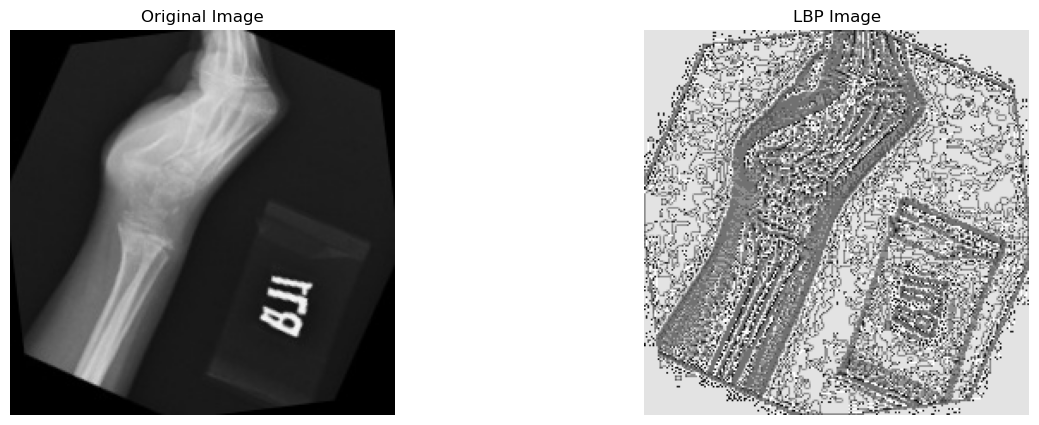

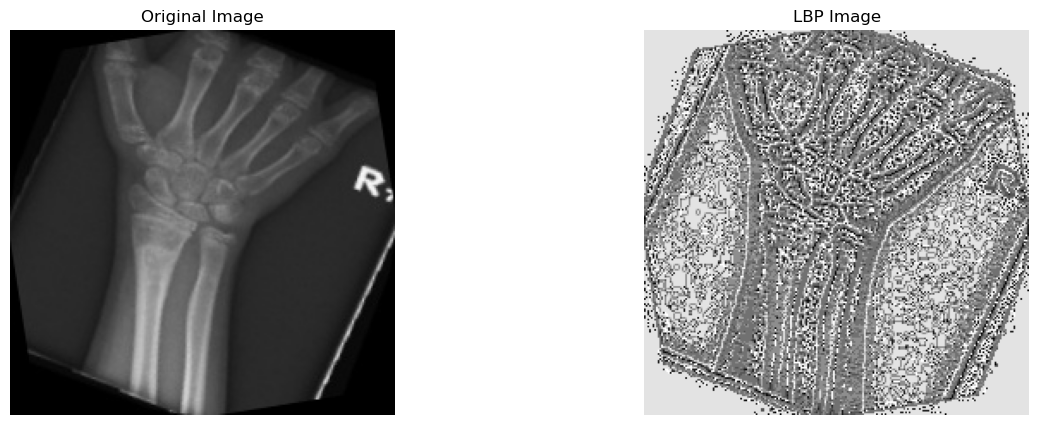

In [ ]:
from skimage.feature import local_binary_pattern

def feature_extraction_lbp(image, show_images=False):


    # Prepare the image for LBP
    gray = prepare_image(image, 'LBP')

    # LBP parameters
    radius = 1
    n_points = 8 * radius

    lbp = local_binary_pattern(gray, n_points, radius, method='uniform') # reduces the number of patterns

    if show_images:
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(lbp, cmap="gray")
        plt.title("LBP Image")
        plt.axis("off")

       
    return lbp

image_paths = gb.glob(os.path.join(path_train, '*/*.jpg'))  # Get all image paths
random_images = random.sample(image_paths, 5)  # Randomly select 5 unique images

for image_path in random_images:
    image = cv2.imread(image_path)
    lbp_features = feature_extraction_lbp(image, show_images=True)
    print(f"Extracted LPB Features: {lbp_features}")

# feature_extraction_glcm 

Extracted GLCM Features: [19.92961243  1.37487988  0.7159878   0.27023172  0.9950332 ]
Extracted GLCM Features: [41.25900865  2.34973575  0.66214507  0.31648489  0.99193549]
Extracted GLCM Features: [67.32016736  2.92867152  0.60908486  0.23326132  0.98215919]
Extracted GLCM Features: [40.91495836  3.07431134  0.51442221  0.14618841  0.99315104]
Extracted GLCM Features: [1.26625761e+02 5.38512972e+00 3.73867190e-01 7.51025056e-02
 9.72613451e-01]


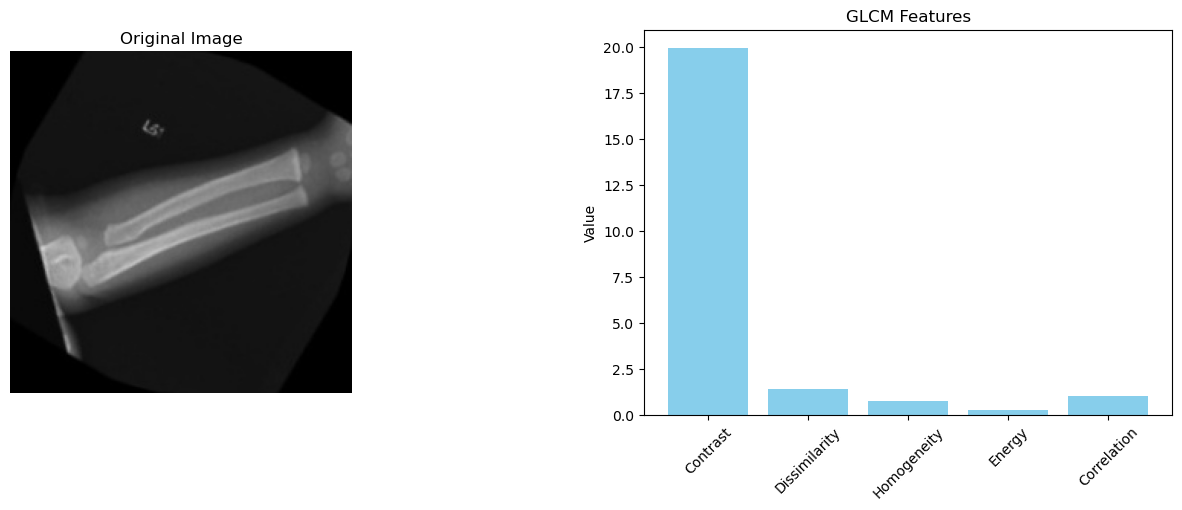

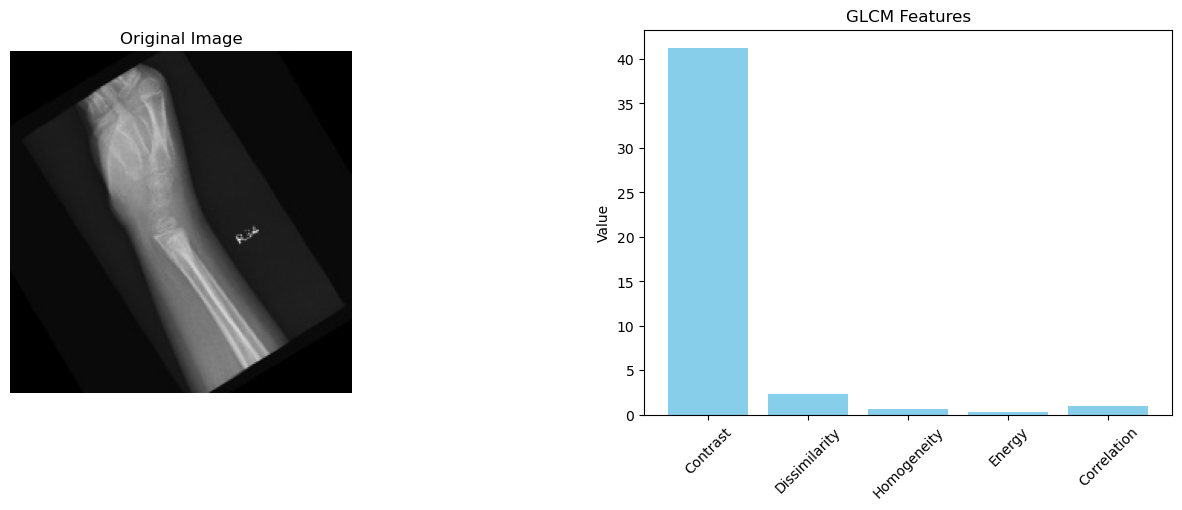

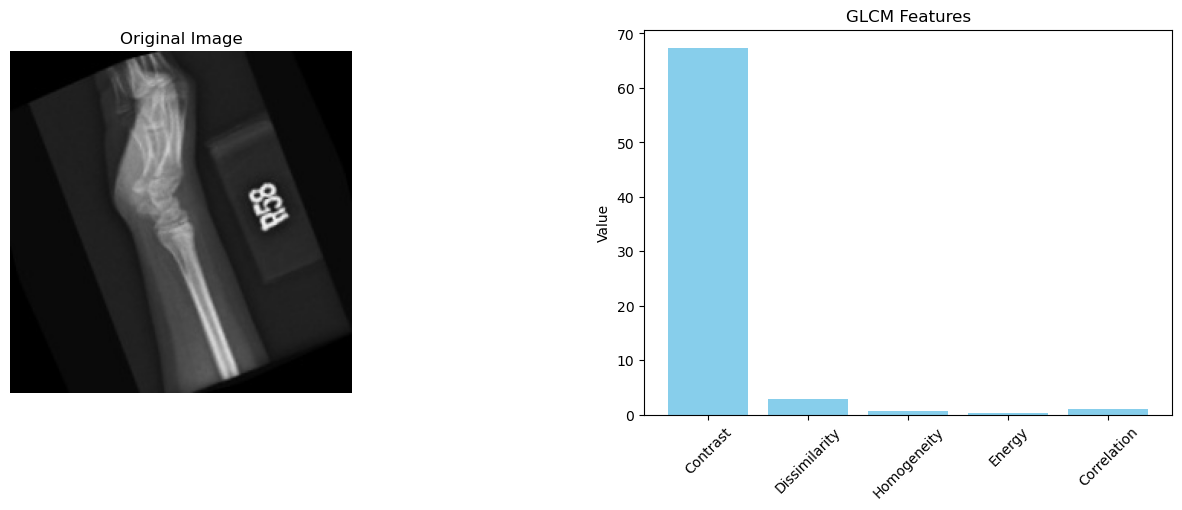

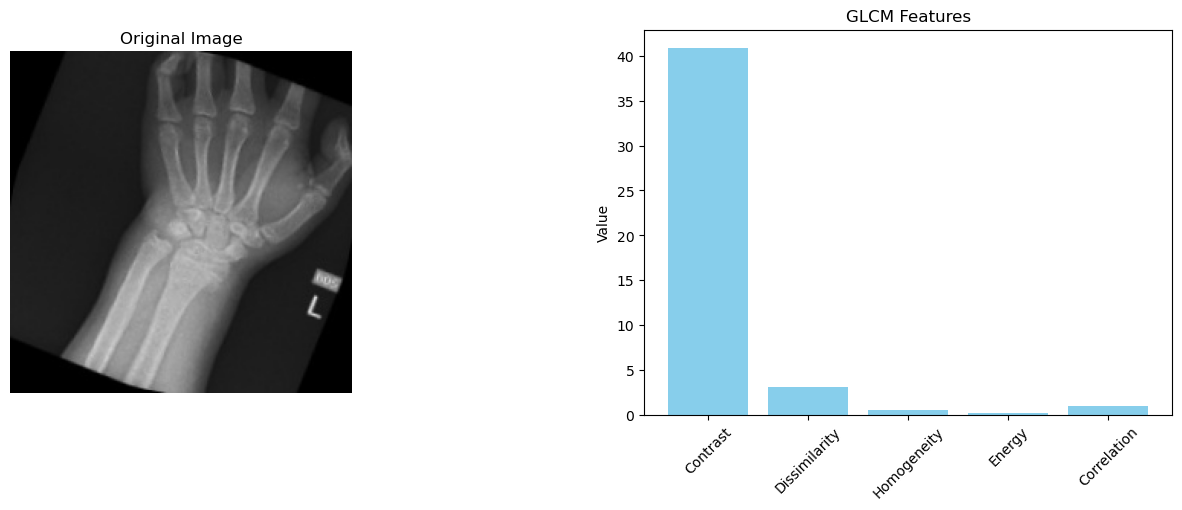

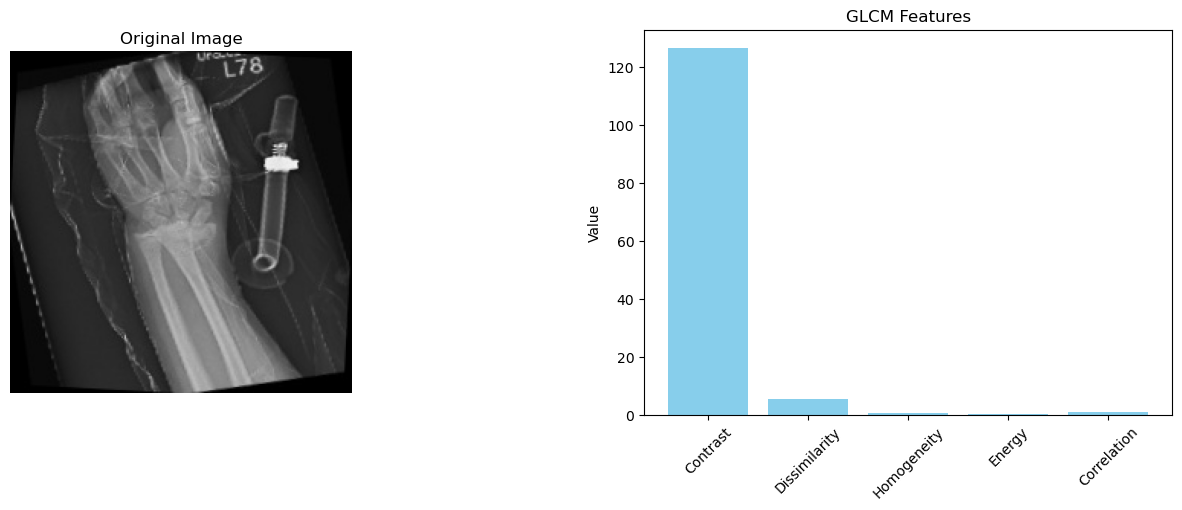

In [ ]:
def feature_extraction_glcm(image, show_images=False):

    # Prepare the image for GLCM
    gray = prepare_image(image, 'GLCM')

    # Compute the GLCM matrix
    distances = [1]  # Pixel pair distance
    angles = [0]     # Angle in radians (0 degrees)
    glcm = graycomatrix(gray, distances=distances, angles=angles, symmetric=True, normed=True)

    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]

    features = np.array([contrast, dissimilarity, homogeneity, energy, correlation])

    if show_images:
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title("Original Image")
        plt.axis("off")


        plt.subplot(1, 2, 2)
        feature_labels = ['Contrast', 'Dissimilarity', 'Homogeneity', 'Energy', 'Correlation']
        plt.bar(feature_labels, features, color='skyblue')
        plt.title("GLCM Features")
        plt.ylabel("Value")
        plt.xticks(rotation=45)



    return features


image_paths = gb.glob(os.path.join(path_train, '*/*.jpg')) 
random_images = random.sample(image_paths, 5) 

for image_path in random_images:
    image = cv2.imread(image_path)
    glcm_features = feature_extraction_glcm(image, show_images=True)
    print(f"Extracted GLCM Features: {glcm_features}")

In [38]:
def feature_extraction(image, method='SIFT'):
  
    if method == 'chain_code':
        return feature_extraction_chain_code(image)
    elif method == 'regional':
        return feature_extraction_regional(image)
    elif method == 'GLCM':
        return feature_extraction_glcm(image)
    elif method == 'LBP':
        return feature_extraction_lbp(image)
    else:
        raise ValueError(f"Unsupported method: {method}")


In [39]:
labels = {"fractured" : 0 , "not fractured" : 1}

# Load Datasets

In [40]:
def load_data(path, target_size=(224, 224)): 
    X, y = [], []
    labels = {'fractured': 0, 'not fractured': 1}  # Update based on folder names
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        files = gb.glob(os.path.join(folder_path, "*.jpg"))
        for file in files:
            image = cv2.imread(file)
            if image is not None:  # Check if image is loaded correctly
                image = cv2.resize(image, target_size)  # Resize image
                X.append(image)
                y.append(labels[folder])
    return np.array(X), np.array(y)

In [41]:
# Load data
X_train, y_train = load_data(path_train)
X_test, y_test = load_data(path_test)

In [42]:
print(f"Len X Train Is == {len(X_train)}")
print(f"Len X Test Is == {len(X_test)}")

Len X Train Is == 8858
Len X Test Is == 598


In [43]:
X_train , X_test , y_train , y_test = train_test_split(X_train , y_train , test_size=0.2 , random_state=42 , shuffle=True)


print(f"X Train Shape is ==> {X_train.shape}")
print(f"X test Shape is ==> {X_test.shape}")
print(f"y train Shape is ==> {y_train.shape}")
print(f"y test Shape is ==> {y_test.shape}")

X Train Shape is ==> (7086, 224, 224, 3)
X test Shape is ==> (1772, 224, 224, 3)
y train Shape is ==> (7086,)
y test Shape is ==> (1772,)


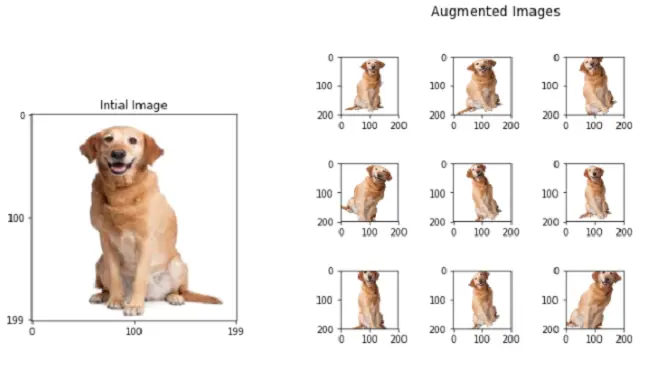

In [44]:
datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = datagen.flow(X_train, y_train, batch_size=32)
test_generator = datagen.flow(X_test, y_test, batch_size=32)

# Model Deep Learning 

In [48]:
model = Sequential([
    Flatten(input_shape=(224, 224, 3)),  
    Dense(256, activation='relu'),       
    BatchNormalization(),                
    Dropout(0.5),                      
    Dense(128, activation='relu'),      
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')     
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, verbose=1, restore_best_weights=True)
]



history = model.fit(
    train_generator  ,             
    validation_data=(test_generator),  
    epochs=10,                        
    callbacks=callbacks              
)

# model.save("fracture.h5")
# print("Model saved as fracture.h5")

# with open("fracture.pkl", "wb") as pkl_file:
#     pickle.dump(model, pkl_file)
# print("Model saved as fracture.pkl")

d:\python\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
d:\python\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 112s 483ms/step - accuracy: 0.5650 - loss: 0.8619 - val_accuracy: 0.6716 - val_loss: 0.5964
Epoch 2/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 108s 486ms/step - accuracy: 0.6422 - loss: 0.6459 - val_accuracy: 0.6512 - val_loss: 0.5819
Epoch 3/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 112s 506ms/step - accuracy: 0.6990 - loss: 0.5725 - val_accuracy: 0.7833 - val_loss: 0.4895
Epoch 4/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 111s 501ms/step - accuracy: 0.7337 - loss: 0.5241 - val_accuracy: 0.7630 - val_loss: 0.4881
Epoch 5/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 138s 621ms/step - accuracy: 0.7727 - loss: 0.4822 - val_accuracy: 0.8251 - val_loss: 0.4379
Epoch 6/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 127s 573ms/step - accuracy: 0.7637 - loss: 0.4805 - val_accuracy: 0.7997 - val_loss: 0.4556
Epoch 7/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 117s 526ms/step - accuracy: 0.7734 - loss: 0.4677 - val_accuracy: 0.7765 - val_loss: 0.4727
Epoch 8/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 108s 486ms/step - accuracy: 0.7830 -

In [49]:
loss , acc = model.evaluate(train_generator)
print(f"Loss Training is == > {loss}")
print(f"Accurcy Training is == > {acc}")

222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.8786 - loss: 0.3395
Loss Training is == > 0.34799331426620483
Accurcy Training is == > 0.8741179704666138


In [50]:
loss , acc = model.evaluate(test_generator)
print(f"Loss Testing is == > {loss}")

print(f"Accurcy Testing is == > {acc}")

56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8342 - loss: 0.4243
Loss Testing is == > 0.40820109844207764
Accurcy Testing is == > 0.8453724384307861


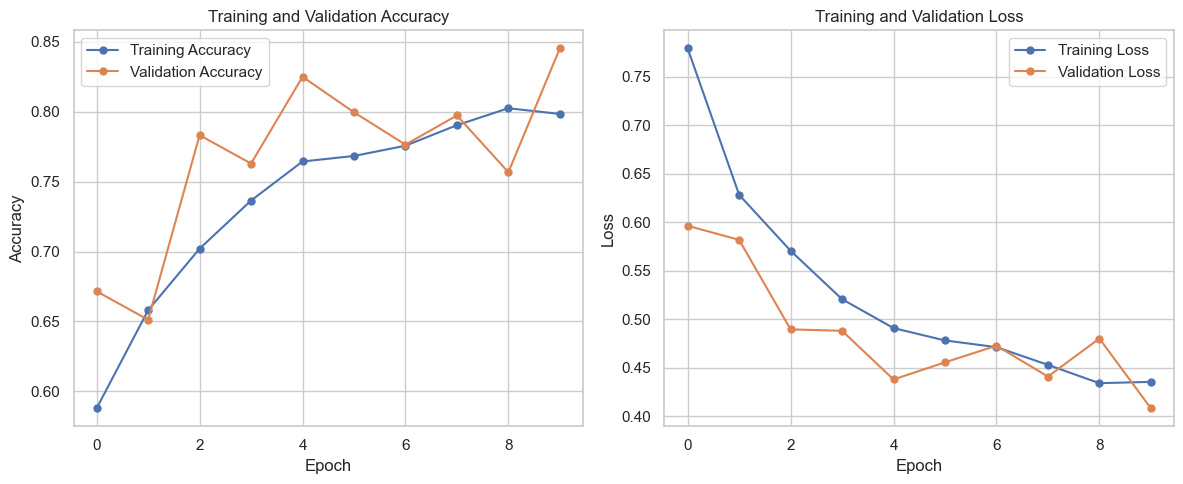

In [51]:
# The style
sns.set(style='whitegrid')

# Plotting training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', linestyle='-', marker='o', markersize=5)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='-', marker='o', markersize=5)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', linestyle='-', marker='o', markersize=5)
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='-', marker='o', markersize=5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [62]:
def getlab(n):
    for x, y in labels.items():
        if n == y:
            return x

In [57]:
pred = model.predict(test_generator)
pred = (pred > 0.5).astype(int)
print(pd.DataFrame(pred[:10] , columns=["Prediction"]))

56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step
   Prediction
0           1
1           0
2           0
3           1
4           1
5           0
6           0
7           1
8           0
9           0


In [58]:
cm = confusion_matrix(y_pred=pred , y_true=y_test)
cm

array([[423, 465],
       [449, 435]], dtype=int64)

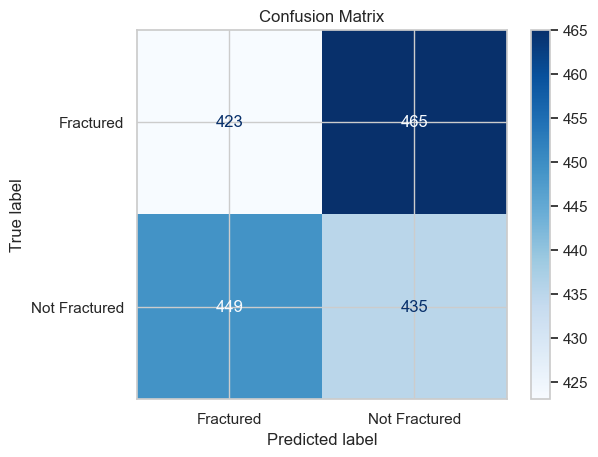

In [59]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fractured", "Not Fractured"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [60]:
print(classification_report(y_test, pred, target_names=["fractured", "not fractured"]))

               precision    recall  f1-score   support

    fractured       0.49      0.48      0.48       888
not fractured       0.48      0.49      0.49       884

     accuracy                           0.48      1772
    macro avg       0.48      0.48      0.48      1772
 weighted avg       0.48      0.48      0.48      1772



In [61]:
len(X_test)

1772

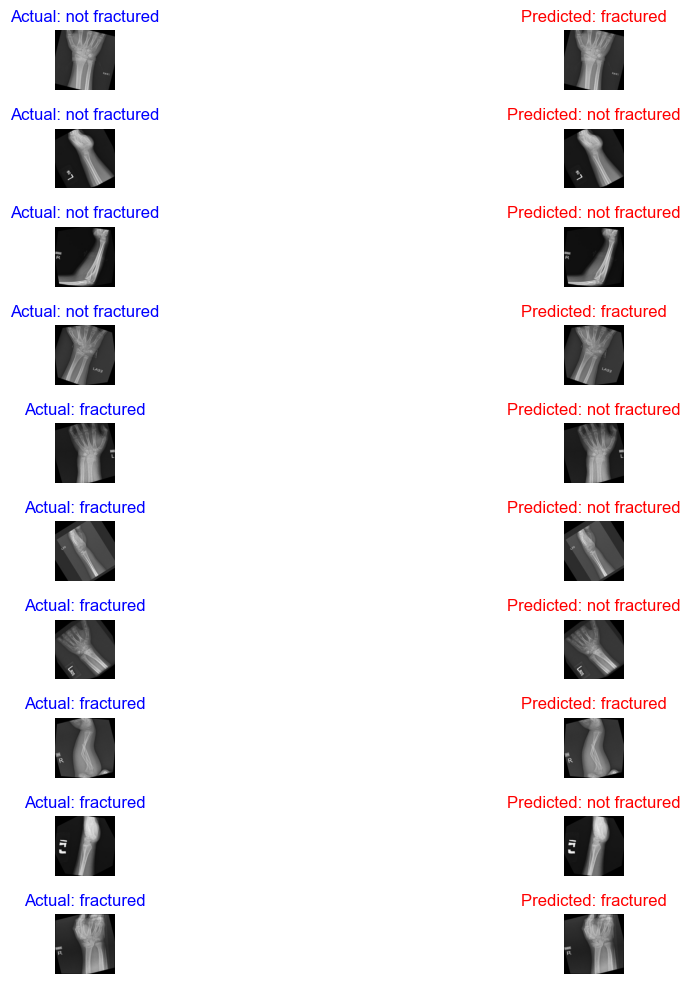

In [63]:
num_images = 10

# Randomly select indices             # 1773        10 
sample_indices = np.random.randint(0, len(X_test), num_images)

plt.figure(figsize=(15, 10))

for n, i in enumerate(sample_indices):
    actual_img = X_test[i]
    actual_label = y_test[i]

    pred_label = (pred[i] > 0.5).astype(int)

    plt.subplot(num_images, 2, n * 2 + 1)
    plt.imshow(cv2.cvtColor(actual_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Actual: {getlab(actual_label)}", color="blue", fontsize=12)
    plt.axis('off')

    plt.subplot(num_images, 2, n * 2 + 2)
    plt.imshow(cv2.cvtColor(actual_img, cv2.COLOR_BGR2RGB)) 
    plt.title(f"Predicted: {getlab(pred_label)}", color="red", fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()

# END 